In [1]:
# !pip install opencv-python transformers accelerate insightface
import diffusers
from diffusers.utils import load_image
from diffusers.models import ControlNetModel

import cv2
import torch
import numpy as np
from PIL import Image

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline, draw_kps

# prepare 'antelopev2' under ./models
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# prepare models under ./checkpoints
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'

# load IdentityNet
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)

base_model = 'cagliostrolab/animagine-xl-3.1'
pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    base_model,
    controlnet=controlnet,
    torch_dtype=torch.float16
)

# VRAM潤沢にある場合は以下の2行は不要。かわりに.cuda()を入れる
pipe.enable_model_cpu_offload()
pipe.enable_vae_tiling()
# pipe.cuda()

# load adapter
pipe.load_ip_adapter_instantid(face_adapter)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

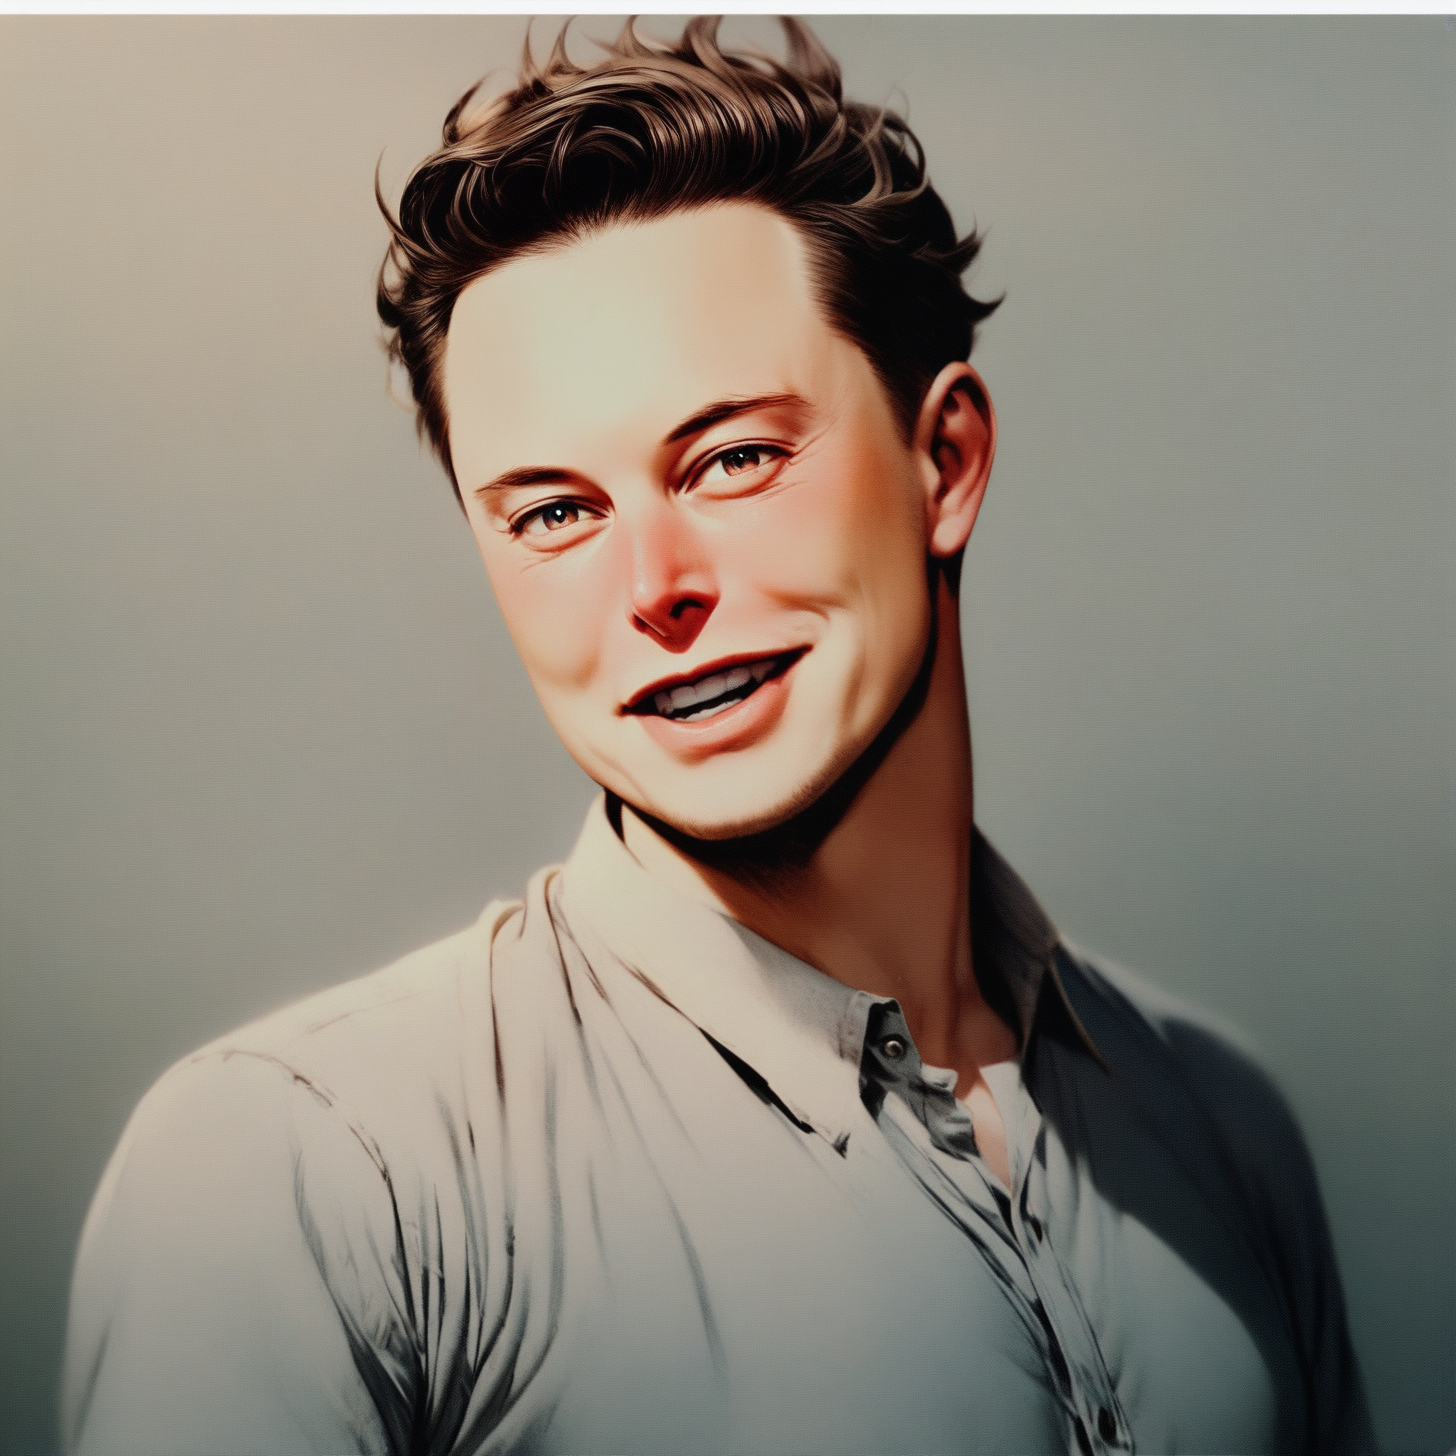

In [13]:
# load an image
face_image = load_image("./examples/musk_resize.jpeg")

# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1]  # only use the maximum face
face_emb = face_info['embedding']
face_kps = draw_kps(face_image, face_info['kps'])

# prompt
prompt = "1man, standing, upper body, best quality"
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

# generate image
image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image_embeds=face_emb,
    image=face_kps,
    controlnet_conditioning_scale=0.7,
    ip_adapter_scale=0.6,
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

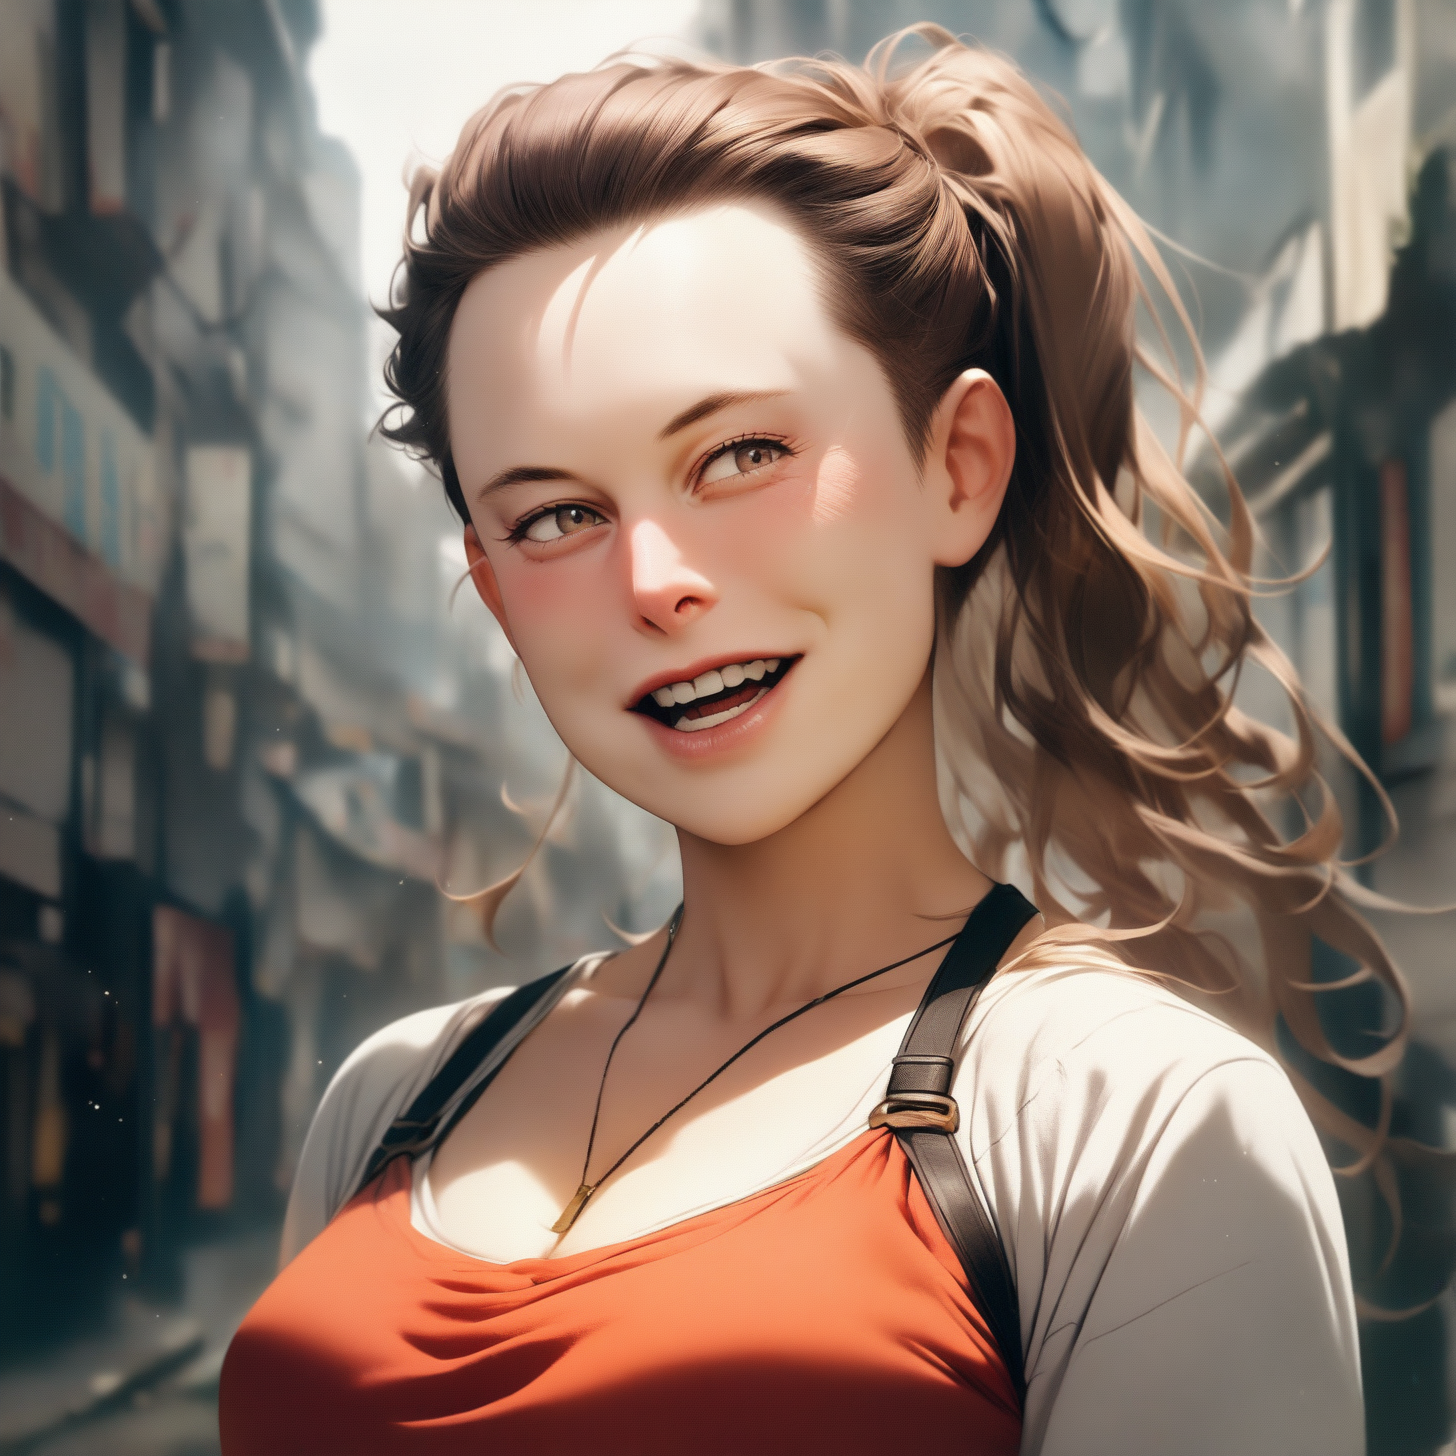

In [16]:
prompt = "1girl, standing, upper body, best quality"
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

# generate image
image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image_embeds=face_emb,
    image=face_kps,
    controlnet_conditioning_scale=0.6,
    ip_adapter_scale=0.4,
).images[0]
image

In [ ]:
## 11-12GB程度